## Individual Assignment 1, International Climate Policy

- Neil Stein, 12410247

- [Github URL](https://github.com/neil-stein/Assignment-2_ICP.git)

In [12]:
# Setup steps
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas
import warnings
import scipy
import time
import re
import scipy

warnings.filterwarnings("ignore")

# data loading steps
county_df = pd.read_csv("icp_indiv_2_county_avetemp.csv")
rep_df = pd.read_csv("icp_indiv_2_dg2011_rep_nomiss.csv")

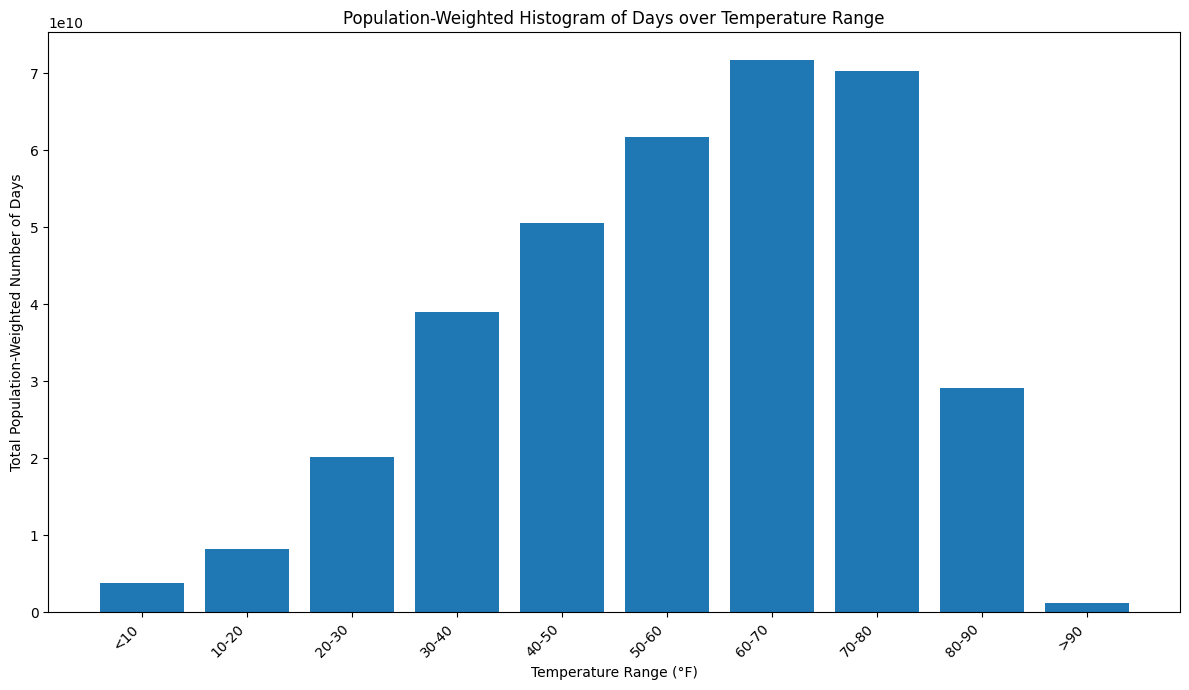

In [13]:
# Part 1(a) -- plotting temp and US population

# creating a merged dataset 
merged_df = pd.merge(rep_df, county_df, left_on= "countycode", right_on= "countycode", how= "left")

# recategorizing our temperature range columns into more precise values
temp_range_pattern = re.compile(r'tday_(lt\d+|gt\d+|\d+_\d+)')
temp_range_cols  = [col for col in merged_df.columns if temp_range_pattern.match(col)]

# duplicating the dataframe to avoid messy crossover between temperature weights
popweight_tempdf = merged_df.copy()

# applying the weights
for temp_col in temp_range_cols:
    popweight_tempdf[f'weighted_{temp_col}'] = popweight_tempdf[temp_col] * popweight_tempdf['population']

# Aggregate the population-weighted days across all rows (summing for each weighted temperature column)
total_weighted_days = popweight_tempdf[[col for col in popweight_tempdf.columns if col.startswith('weighted_tday_')]].sum()

# Prepare labels for the x-axis
bin_labels = [col.replace('weighted_tday_', '').replace('lt', '<').replace('gt', '>').replace('_', '-') for col in total_weighted_days.index]
bin_values = total_weighted_days.values

# Create the histogram
plt.figure(figsize=(12, 7))
plt.bar(bin_labels, bin_values)
plt.xlabel("Temperature Range (°F)")
plt.ylabel("Total Population-Weighted Number of Days")
plt.title("Population-Weighted Histogram of Days over Temperature Range")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# Part 1(b) - number of days about 90°F as a population weighted average
# first, we need the total population in the context of this data
total_pop = popweight_tempdf['population'].sum()

# next, the population weighted days above 90°F
total_above90 = popweight_tempdf['weighted_tday_gt90'].sum()

# last, creating our population weighted average
popweight_avg_over90 = total_above90/total_pop
print(f'The population-weighted average number of days above 90°F per year across the US is: {popweight_avg_over90:.2f} days.')

The population-weighted average number of days above 90°F per year across the US is: 1.21 days.


In [15]:
# Part 1(c) - finding the max and the non-90°F locations

# first, our county with the most days above 90°F
county_above90 = popweight_tempdf.groupby('county_x')['tday_gt90'].max()
county_with_highest_above_90 = county_above90.idxmax()
max_days_above_90 = county_above90.max()

print(f'The county with the most days above 90°F is {county_with_highest_above_90} with {max_days_above_90:.0f} days')

# next, counting the number of counties without 90°F days
zero_days_above_90_df = popweight_tempdf[popweight_tempdf['tday_gt90'] == 0]
unique_counties_with_zero_days = zero_days_above_90_df['county_x'].unique()
num_unique_counties_with_zero_days = len(unique_counties_with_zero_days)
print(f'The number of counties with zero days above 90°F is: {num_unique_counties_with_zero_days}')

The county with the most days above 90°F is Yuma County, AZ with 100 days
The number of counties with zero days above 90°F is: 2894


# 2(a) - pre-question

As the prompt suggests, I searched for the national all age mortality rate during the latest time period of the data (2002) before exploring the data-based approach. I found that value to be __845.3 deaths per 100,000__, otherwise represented as a life expectancy of __77.3 years__.

Source: [United States Life Tables, 2002 - CDC](https://www.cdc.gov/nchs/data/nvsr/nvsr53/nvsr53_06.pdf)

In [16]:
# 2(a) - calculating the national average over-65 mortality rate

over65_mort = popweight_tempdf.groupby('county_x')[['deaths', 'population']].mean()
over65_mort['mort_rate'] = over65_mort['deaths'] / over65_mort['population']

natavg_over65mort = over65_mort['mort_rate'].mean()
natpercent_over65mort = natavg_over65mort * 100000

print(f'The national average mortality rate of individuals over 65 is:{natpercent_over65mort: .1f} per 100,000')

The national average mortality rate of individuals over 65 is: 5321.7 per 100,000


# 2(a) post-data analysis

This data shows that there is just over 6x higher mortality rate among individuals over 65 (5321.7 per 100,000) as compared to the CDC life table value I found (845.3 per 100,000) for the general population

In [17]:
# 2(b) total deaths

tot_deaths = rep_df['deaths'].sum()
print(f'There are {tot_deaths:,} total deaths in the data from 1968 - 2002')

There are 50,830,306 total deaths in the data from 1968 - 2002


Slope: -3.5710626708150506
Intercept: 5366.561252203591


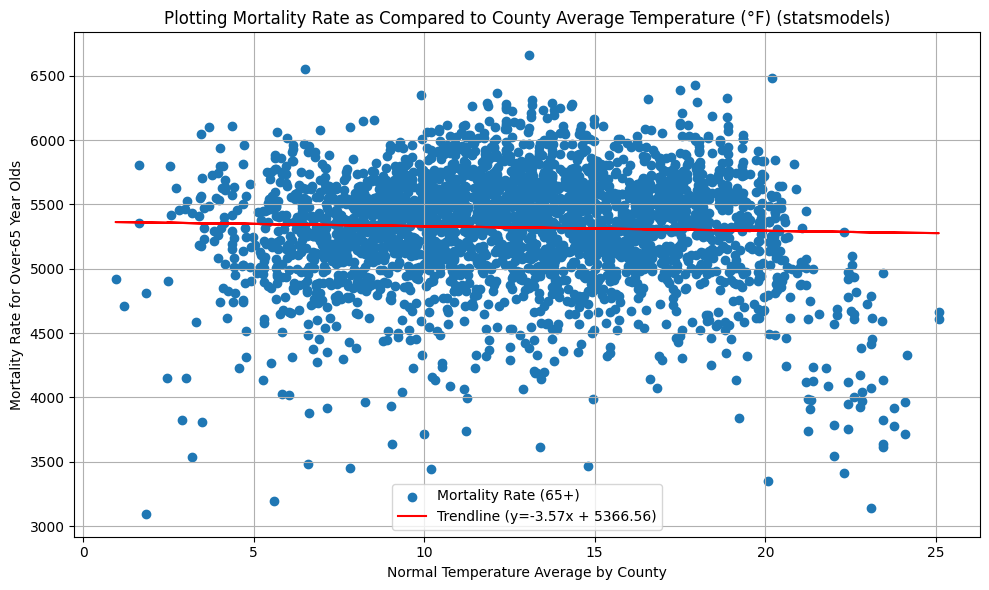

In [18]:
# 3(a)  exploring the relationship between county avg temp and over-65 mortality

# first, the suggested new columns in our data
popweight_tempdf['hot_days'] = popweight_tempdf['tday_70_80'] + popweight_tempdf['tday_80_90'] + popweight_tempdf['tday_gt90']
popweight_tempdf['hotter_days'] = popweight_tempdf['tday_80_90'] + popweight_tempdf['tday_gt90']

# next, grouping the counties and calculating mortality
avgtemp_over65df = popweight_tempdf.groupby('county_x')[['deaths','population','hot_days','hotter_days','normal_1981_2010']].mean()
avgtemp_over65df['mort_rate'] = avgtemp_over65df['deaths'] / avgtemp_over65df['population']
avgtemp_over65df['mort_rate'] = avgtemp_over65df['mort_rate'] * 100000


# next, creating linear regression
model = smf.ols('mort_rate ~ normal_1981_2010', data= avgtemp_over65df)
results = model.fit()
avg_slope_sm = results.params['normal_1981_2010']
avg_intercept_sm = results.params['Intercept']

# printing the components of the linear regression
print(f'Slope: {avg_slope_sm}')
print(f'Intercept: {avg_intercept_sm}')

# last, plotting with the trendline
avg_trendline_sm = avg_intercept_sm + avg_slope_sm * avgtemp_over65df['normal_1981_2010']
plt.figure(figsize=(10, 6))
plt.scatter(avgtemp_over65df['normal_1981_2010'], avgtemp_over65df['mort_rate'], label='Mortality Rate (65+)')
plt.plot(avgtemp_over65df['normal_1981_2010'], avg_trendline_sm, color= 'red', linestyle='-', label=f'Trendline (y={avg_slope_sm:.2f}x + {avg_intercept_sm:.2f})')
plt.xlabel("Normal Temperature Average by County")
plt.ylabel("Mortality Rate for Over-65 Year Olds")
plt.title("Plotting Mortality Rate as Compared to County Average Temperature (°F) (statsmodels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3(a) - interpreting our results

The slope for this trendline is lightly negative,__~-3.57 persons per 100,000 decrease in mortality rate for every °F increase in average temperature__. However, looking at the broader trend, there is a cluster and curvateur to the scatter plot which would indicate that there is a non-linearity in this relationship, suggesting that some counties have a decreasing mortality rate effect as temperature increases. This may be due to the fact that wealthier, warm areas tend to have great medical care, or else the areas of extreme heat in states such as Nevada tend to drive away the elderly, leading to a decrease in the sample population.

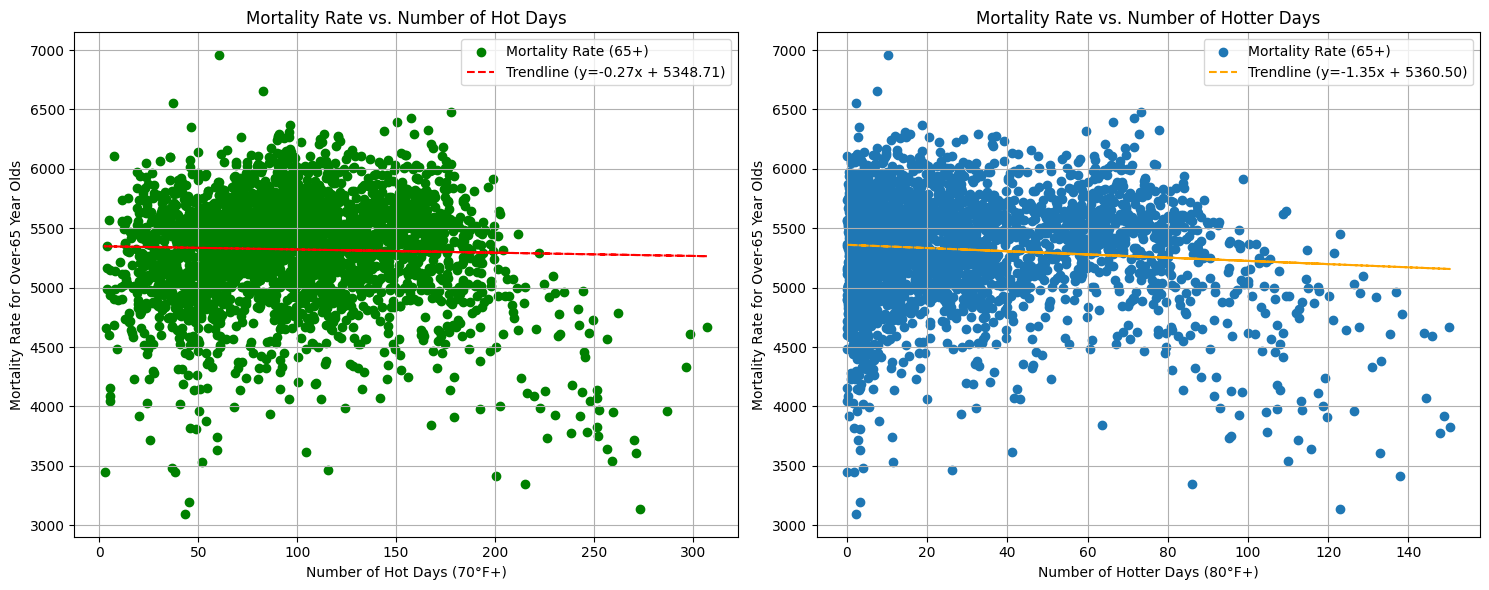

The slope of the trendline for hot days is -0.2732
The slope of the trendline for hotter days is -1.3543


In [19]:
# 3(b) - checking for extreme days 

# first, regressing for hot days

hot_model = smf.ols('mort_rate ~ hot_days', data= avgtemp_over65df)
hot_results = hot_model.fit()
hot_slope_sm = hot_results.params['hot_days']
hot_intercept_sm = hot_results.params['Intercept']

# next, regressing for hotter days

hotter_model = smf.ols('mort_rate ~ hotter_days', data= avgtemp_over65df)
hotter_results = hotter_model.fit()
hotter_slope_sm = hotter_results.params['hotter_days']
hotter_intercept_sm = hotter_results.params['Intercept']

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for 'hotdays'
axes[0].scatter(avgtemp_over65df['hot_days'], avgtemp_over65df['mort_rate'], color= 'green', label='Mortality Rate (65+)')
hot_trendline = hot_intercept_sm + hot_slope_sm * avgtemp_over65df['hot_days']
axes[0].plot(avgtemp_over65df['hot_days'], hot_trendline, color='red', linestyle='--', label=f'Trendline (y={hot_slope_sm:.2f}x + {hot_intercept_sm:.2f})')
axes[0].set_xlabel("Number of Hot Days (70°F+)")
axes[0].set_ylabel("Mortality Rate for Over-65 Year Olds")
axes[0].set_title("Mortality Rate vs. Number of Hot Days")
axes[0].legend()
axes[0].grid(True)

# Plot for 'hotterdays'
axes[1].scatter(avgtemp_over65df['hotter_days'], avgtemp_over65df['mort_rate'], label='Mortality Rate (65+)')
hotter_trendline = hotter_intercept_sm + hotter_slope_sm * avgtemp_over65df['hotter_days']
axes[1].plot(avgtemp_over65df['hotter_days'], hotter_trendline, color='orange', linestyle='--', label=f'Trendline (y={hotter_slope_sm:.2f}x + {hotter_intercept_sm:.2f})')
axes[1].set_xlabel("Number of Hotter Days (80°F+)")
axes[1].set_ylabel("Mortality Rate for Over-65 Year Olds")
axes[1].set_title("Mortality Rate vs. Number of Hotter Days")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f'The slope of the trendline for hot days is {hot_slope_sm:.4f}')
print(f'The slope of the trendline for hotter days is {hotter_slope_sm:.4f}')

# 3(b) - interpretation

Looking at our resulting charts and slope lines, we can see that there is a more pronounced trend with the __hotter days than the hot days__ data. In the context of our data, we would predict that there is a sharper decrease in mortality rate (-1.35 vs. -0.27) for every increased number of hotter days as opposed to hot days.

# 3(c) - Interpreting our overall results 

Throughout problem #3 we have been exploring the relationship between temperature and mortality rate, and in general we have observed a surprising decrease in mortality as temperature increases, whether that be the number of hot (70°F+) days, hotter days (80°F+), or average normal temperature. While it is true that humans generally are at higher risk for heatstroke, dehydration, etc. at higher temperatures, this trend has appeared in our data, below are a two key potential explanations for this phenomenon come to mind:

- __Unmeasured variance due to wealth__: Some of the wealthiest areas in the United States are located in the warmer areas (Los Angeles, Miami, etc.) and wealthier individuals generally are able to access better quality of healthcare. It is common practice for older individuals to also migrate from colder regions to warmer later in life, adding to the potential confounds in this data.
- __Skew due to represented age demographic__: This dataset only includes death for individuals over the age of 65, when we know that there are compounding health factors for people of this age that is skewing the data. We noted this in part 2(a) that the overall national mortality rate at the time of the data (2002) was 6x less than the found mortality rate in this deaths data, leading to a skewed focus.

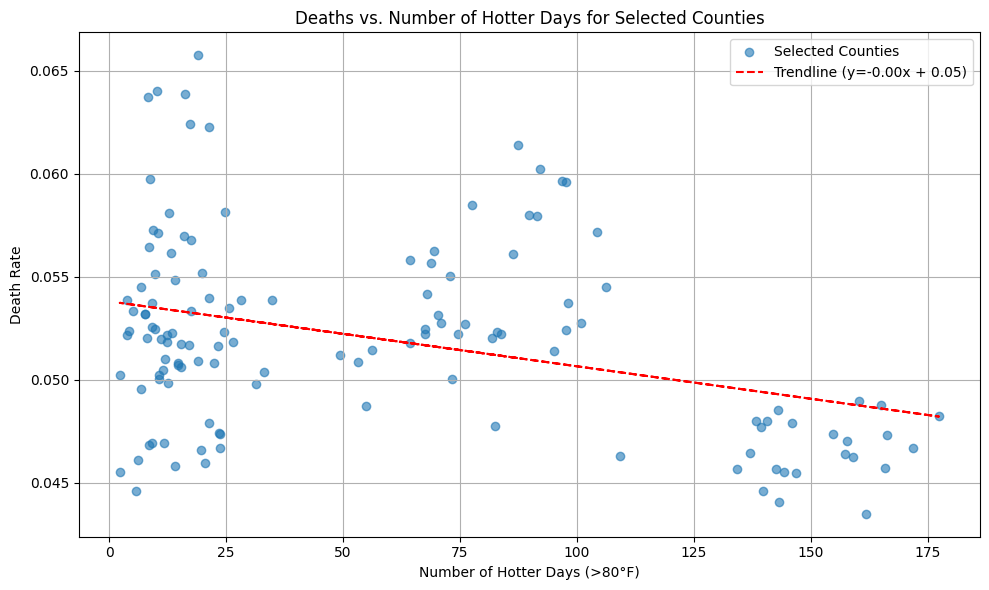

In [31]:
# 4(a) - scatter plot of all counties mortality rates

# reloading the original df, re-adding the hot & hotter designations
new_merge_df = pd.merge(rep_df, county_df, left_on= "countycode", right_on= "countycode", how= "left")
new_merge_df['hot_days'] = new_merge_df['tday_70_80'] + new_merge_df['tday_80_90'] + new_merge_df['tday_gt90']
new_merge_df['hotter_days'] = new_merge_df['tday_80_90'] + new_merge_df['tday_gt90']
new_merge_df['death_rate'] = new_merge_df['deaths'] / new_merge_df['population']

# creating a list of counties to keep, dropping the rest
target_counties = ['Mobile County, AL', 'Miami-Dade County, FL', 'Cook County, IL', 'Los Angeles County, CA']
target_counties_df = new_merge_df[new_merge_df['county_x'].isin(target_counties)]

# plotting all the counties together
all_counties_model = smf.ols('death_rate ~ hotter_days', data=target_counties_df)
all_counties_results = all_counties_model.fit()
all_counties_slope = all_counties_results.params['hotter_days']
all_counties_intercept = all_counties_results.params['Intercept']
all_counties_trendline = all_counties_intercept + all_counties_slope * target_counties_df['hotter_days']

# Create the scatter plot for the subset of counties
plt.figure(figsize=(10, 6))
plt.scatter(target_counties_df['hotter_days'], target_counties_df['death_rate'], label='Selected Counties', alpha=0.6)

# Plot the actual trendline
plt.plot(target_counties_df['hotter_days'], all_counties_trendline, color='red', linestyle='--', label=f'Trendline (y={all_counties_slope:.2f}x + {all_counties_intercept:.2f})')

plt.xlabel("Number of Hotter Days (>80°F)")
plt.ylabel("Death Rate")
plt.title("Deaths vs. Number of Hotter Days for Selected Counties")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4(a) - interpretation

Looking at the chart above, we can see that there is a similar downward trend line to the earlier questions where we explored the entire population, however given that our counties are very different from each other in population size (#1, #2, #7, and #137 for LA County, Cook County, Miami-Dade County, and Mobile County respectively) we are likely not viewing this relationship in the most meaningful format. 

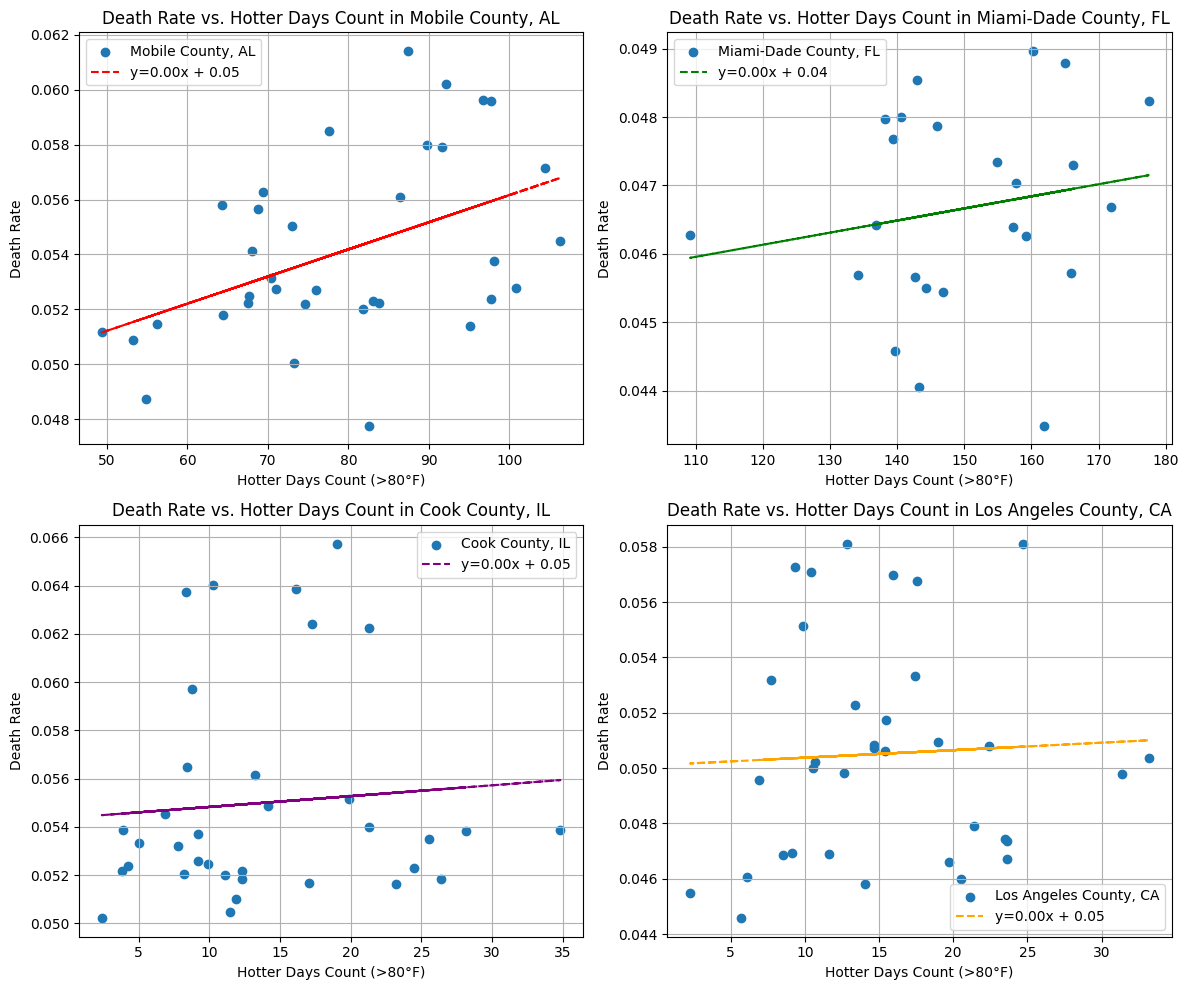

In [32]:
# 4(b) - scatter plot of specific counties separated

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# plot for Mobile County, AL
mobile_df = target_counties_df[target_counties_df['county_x'] == 'Mobile County, AL']
mobile_model = smf.ols('death_rate ~ hotter_days', data=mobile_df).fit()
mobile_slope = mobile_model.params['hotter_days']
mobile_intercept = mobile_model.params['Intercept']
mobile_trendline = mobile_intercept + mobile_slope * mobile_df['hotter_days']
axes[0, 0].scatter(mobile_df['hotter_days'], mobile_df['death_rate'], label='Mobile County, AL')
axes[0, 0].plot(mobile_df['hotter_days'], mobile_trendline, color='red', linestyle='--', label=f'y={mobile_slope:.2f}x + {mobile_intercept:.2f}')
axes[0, 0].set_xlabel("Hotter Days Count (>80°F)")
axes[0, 0].set_ylabel("Death Rate")
axes[0, 0].set_title("Death Rate vs. Hotter Days Count in Mobile County, AL")
axes[0, 0].legend()
axes[0, 0].grid(True)

# plot for Miami-Dade County, FL
miami_df = target_counties_df[target_counties_df['county_x'] == 'Miami-Dade County, FL']
miami_model = smf.ols('death_rate ~ hotter_days', data=miami_df).fit()
miami_slope = miami_model.params['hotter_days']
miami_intercept = miami_model.params['Intercept']
miami_trendline = miami_intercept + miami_slope * miami_df['hotter_days']
axes[0, 1].scatter(miami_df['hotter_days'], miami_df['death_rate'], label='Miami-Dade County, FL')
axes[0, 1].plot(miami_df['hotter_days'], miami_trendline, color='green', linestyle='--', label=f'y={miami_slope:.2f}x + {miami_intercept:.2f}')
axes[0, 1].set_xlabel("Hotter Days Count (>80°F)")
axes[0, 1].set_ylabel("Death Rate")
axes[0, 1].set_title("Death Rate vs. Hotter Days Count in Miami-Dade County, FL")
axes[0, 1].legend()
axes[0, 1].grid(True)

# plot for Cook County, IL
cook_df = target_counties_df[target_counties_df['county_x'] == 'Cook County, IL']
cook_model = smf.ols('death_rate ~ hotter_days', data=cook_df).fit()
cook_slope = cook_model.params['hotter_days']
cook_intercept = cook_model.params['Intercept']
cook_trendline = cook_intercept + cook_slope * cook_df['hotter_days']
axes[1, 0].scatter(cook_df['hotter_days'], cook_df['death_rate'], label='Cook County, IL')
axes[1, 0].plot(cook_df['hotter_days'], cook_trendline, color='purple', linestyle='--', label=f'y={cook_slope:.2f}x + {cook_intercept:.2f}')
axes[1, 0].set_xlabel("Hotter Days Count (>80°F)")
axes[1, 0].set_ylabel("Death Rate")
axes[1, 0].set_title("Death Rate vs. Hotter Days Count in Cook County, IL")
axes[1, 0].legend()
axes[1, 0].grid(True)

# plot for Los Angeles County, CA
la_df = target_counties_df[target_counties_df['county_x'] == 'Los Angeles County, CA']
la_model = smf.ols('death_rate ~ hotter_days', data=la_df).fit()
la_slope = la_model.params['hotter_days']
la_intercept = la_model.params['Intercept']
la_trendline = la_intercept + la_slope * la_df['hotter_days']
axes[1, 1].scatter(la_df['hotter_days'], la_df['death_rate'], label='Los Angeles County, CA')
axes[1, 1].plot(la_df['hotter_days'], la_trendline, color='orange', linestyle='--', label=f'y={la_slope:.2f}x + {la_intercept:.2f}')
axes[1, 1].set_xlabel("Hotter Days Count (>80°F)")
axes[1, 1].set_ylabel("Death Rate")
axes[1, 1].set_title("Death Rate vs. Hotter Days Count in Los Angeles County, CA")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


# 4(b) - interpretation of our output

Looking through the chart in part a, it was difficult to draw a one-size-fits-all conclusion given the spread in population. However, with this separated view, we can see some interesting dynamics, such as the Cook County, IL plot, which indicates an increase in mortality as there is an increase in the number of hotter days per year, which may highlight that _colder climate cities are less prepared to handle hot temperatures, leading to adverse health outcomes and increased mortality_. For our other selected counties, which are located in warmer climates, it appears that the relationship is similar, though it is worth noting that LA County has an essentially zero slope relationship.

My contention here is that we are observing a secondary variable influencing our data, that being wealth, which in the case of LA County, a wealthy, warm location, results in a high degree of preparedness; whereas Mobile County, Alabama, a similarly warm location to Los Angeles, lacks the financial resources to properly adapt to the increased heat. We would generally feel more confident in these sets of relationships as it splits out the key counties we can see similar locations through time. 

['Intercept', 'C(countycode)[T.1003]', 'C(countycode)[T.1005]', 'C(countycode)[T.1007]', 'C(countycode)[T.1009]', 'C(countycode)[T.1011]', 'C(countycode)[T.1013]', 'C(countycode)[T.1015]', 'C(countycode)[T.1017]', 'C(countycode)[T.1019]', 'C(countycode)[T.1021]', 'C(countycode)[T.1023]', 'C(countycode)[T.1025]', 'C(countycode)[T.1027]', 'C(countycode)[T.1029]', 'C(countycode)[T.1031]', 'C(countycode)[T.1033]', 'C(countycode)[T.1035]', 'C(countycode)[T.1037]', 'C(countycode)[T.1039]', 'C(countycode)[T.1041]', 'C(countycode)[T.1043]', 'C(countycode)[T.1045]', 'C(countycode)[T.1047]', 'C(countycode)[T.1049]', 'C(countycode)[T.1051]', 'C(countycode)[T.1053]', 'C(countycode)[T.1055]', 'C(countycode)[T.1057]', 'C(countycode)[T.1059]', 'C(countycode)[T.1061]', 'C(countycode)[T.1063]', 'C(countycode)[T.1065]', 'C(countycode)[T.1067]', 'C(countycode)[T.1069]', 'C(countycode)[T.1071]', 'C(countycode)[T.1073]', 'C(countycode)[T.1075]', 'C(countycode)[T.1077]', 'C(countycode)[T.1079]', 'C(countyco

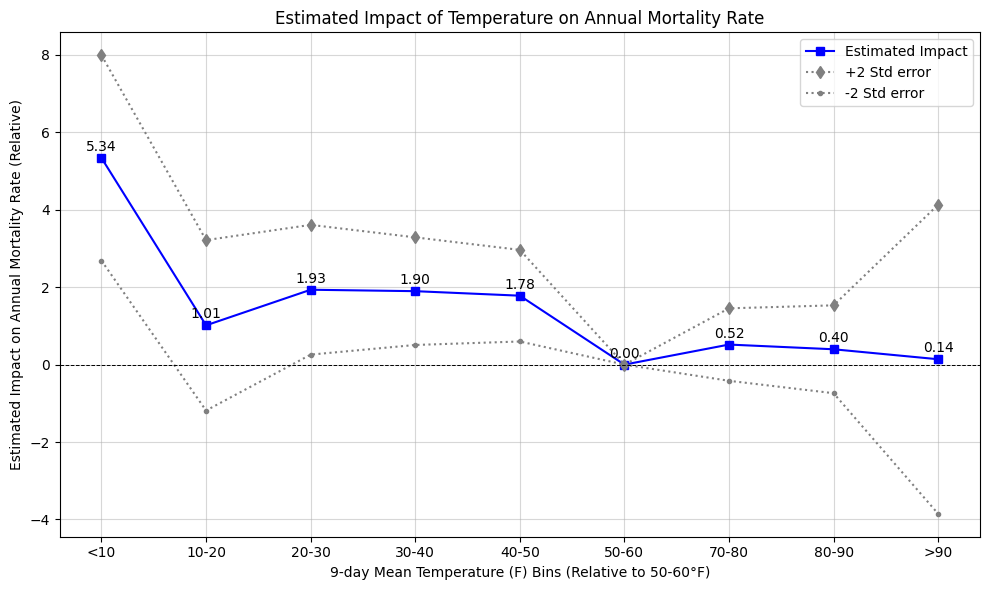

In [30]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# creating a new mortality rate for the re-loaded data
lfe_df = new_merge_df.copy()

# next, grouping the counties and calculating mortality
lfe_df['mort_rate'] = lfe_df['deaths'] / lfe_df['population']
lfe_df['mort_rate'] = lfe_df['mort_rate'] * 100000

# Construct the formula string
formula = ('mort_rate ~ tday_lt10 + tday_10_20 + tday_20_30 + tday_30_40 + tday_40_50 + '
           'tday_50_60 + tday_70_80 + tday_80_90 + tday_gt90 + '
           'prec_10_15 + prec_15_20 + prec_20_25 + prec_25_30 + prec_30_35 + '
           'prec_35_40 + prec_40_45 + prec_45_50 + prec_50_55 + prec_55_60 + prec_gt60 + '
           'C(countycode) + C(ssyy)')

# Fit the Ordinary Least Squares (OLS) model with fixed effects and weights
lfe_model = smf.ols(formula, data= lfe_df, weights= lfe_df['population'])
dg2011_results = lfe_model.fit()

print(model.exog_names)

# Get robust standard errors clustered by countycode AND ASSIGN IT BACK
cluster_groups = lfe_df['countycode']
robust_results = dg2011_results.get_robustcov_results(cov_type='cluster', groups=cluster_groups)


# Extract the coefficients and standard errors for the temperature variables
temp_vars_actual = [
    'tday_lt10', 'tday_10_20', 'tday_20_30', 'tday_30_40', 'tday_40_50',
    'tday_50_60', 'tday_70_80', 'tday_80_90', 'tday_gt90'
]

coefficients = []
std_errors = []
for var in temp_vars_actual:
    try:
        index = model.exog_names.index(var)
        coefficients.append(robust_results.params[index])
        std_errors.append(robust_results.bse[index])
    except ValueError:
        coefficients.append(0)
        std_errors.append(0)

# Set the coefficient for the reference bin (50-60°F) to zero
try:
    reference_bin_index = temp_vars_actual.index('tday_50_60')
    coefficients[reference_bin_index] = 0
    std_errors[reference_bin_index] = 0
except ValueError:
    print("Warning: 'tday_50_60' not found in temperature variables.")

# Calculate the temperature bin labels
temp_bin_labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '70-80', '80-90', '>90']

# Calculate the upper and lower bounds of the confidence intervals (+/- 2 standard errors)
upper_errors = np.array(coefficients) + 2 * np.array(std_errors)
lower_errors = np.array(coefficients) - 2 * np.array(std_errors)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(temp_bin_labels, coefficients, marker='s', linestyle='-', color='blue', label='Estimated Impact')
plt.plot(temp_bin_labels, upper_errors, marker='d', linestyle=':', color='gray', label='+2 Std error')
plt.plot(temp_bin_labels, lower_errors, marker='.', linestyle=':', color='gray', label='-2 Std error')
for i, coef in enumerate(coefficients):
    plt.annotate(f'{coef:.2f}', (temp_bin_labels[i], coef), textcoords="offset points", xytext=(0, 5), ha='center')
plt.xlabel("9-day Mean Temperature (F) Bins (Relative to 50-60°F)")
plt.ylabel("Estimated Impact on Annual Mortality Rate (Relative)")
plt.title("Estimated Impact of Temperature on Annual Mortality Rate")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.7)
plt.grid(True, which='major', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

# 5(a) - Interpretation of our Results

Following the example from the paper that was shared with the homework, I managed to replicate the same style of analysis with the error bars in the data for 5(a). Using the full data, we see a slightly different trend than the DG 2011 paper, in particular as temperature increases we can see that the trend tracks differently. The path found in the DG 2011 paper is contained within the standard error range I found in my iteration of the analysis, so we are at least on the right track with this recreation.

In terms of the particular observed relationship, we can see that __when observing the full data set, we see that an increasing temperature has a weak, but still significant relationship with mortality, meaning that as temperature increases we would predict an increase in mortality, in particular towards the extreme end (>90°F)__. Our analysis here used 50-60°F as the baseline, and looking backwards from there we can also observe a sharp increase in predicted mortality for the lower end of temperature (<10°F), __so on the whole the temperature extremes appear to have a pronounced impact on mortality__.

# 5(b) - Interpretation of the Fixed Effects Included in DG 2011

The DG 2011 paper contains two key fixed effects terms, __α<sub>c</sub> and γ<sub>st</sub>__, which refer to county-by-age fixed effects and state-by-year fixed effects respectively. Practically speaking, the first is designed to account for all county-specific variation factors that impacted the mortality rate by age group, and the second is designed to account for the shared variation within age-groups in the same state. These terms on their own are fairly escoteric, a practical way to think about α<sub>c</sub> is to think of something like a measles outbreak in public elementary schools (such as what's happening in [Texas currently](https://abcnews.go.com/Health/texas-measles-outbreak-surpasses-600-cases-children-teens/story?id=121042863)), a practical way to think about γ<sub>st</sub> is to consider something such as the change in healthcare coverage due to people moving off of their parents' insurance at age 26, interrupting coverage and leading to reluctance to seek medical care even when the circumstances would warrant it.


# 5(c) - Interpretation of our found coefficient

The coefficient value found for >90°F days was 0.14, which in the context of our data is interpreted as us predicting 0.14 fewer annual deaths per 100,000 if we swapped a >90°F day for one at the baseline (50-60°F). This implies a fairly small change (~0.0014%) in the mortality rate, which is fairly surprising, especially considering that the extreme cold end of the spectrum appears to have a far greater impact on the outcome. Given that this just represents death for the over-65 population, this can be interpreted in context as being fairly reasonable, the older population in general lives in warmer climates as they retire, and those who do remain in colder climates are at far greater risk for falls/slippage injuries resulting from extreme cold that contribute to higher mortality rates!

# 6 - Proposing an Extended Analysis

Given the rise of remote work and the general social trend of relocating for a better lifestyle towards the Sunbelt states, I think a reasonable extension of this analysis would be to explore the movement (or lack thereof) based on socio-economic indicators as climate change factors increase. My suspicion is that we will see a flight of wealthier individuals from cold-climate areas to warm-climate areas, such as wealthier people moving from New York to Florida, with poorer people in those areas being progressively priced out and moved towards more climatically-hazardous areas with extreme temperatures, flood risks, etc. 

The movement of wealth in this manner is likely, in my estimation, to create pockets of higher life expectancy within large regions of poorer mortality, such as Miami-Dade County improving but nearby Broward County regressing as the wealth & healthcare resources concentrate in certain areas as temperatures increasingly heat the Earth and put pressure on populations in the USA.

# 7 - Considering the Implications

Looking through the results from this analysis and placing our findings in the context of the work, __we can see a horse-shoe shaped dynamic with temperature correlating to mortality__ meaning an increase on the extremes and a settling effect towards the middle. Incorporating fixed effects here as we did in question 5 could help explain why the earlier analysis (such as part 3(a)) had that curving effect in the scatter plot that was not well-explained in our earlier analyses. The implications of these results are dire for the United States, especially considering recent migration trends to Sunbelt States, where global warming is predicted to be particularly harsh. It should also be noted that while global warming is occuring, we also predict there to be more days of extreme cold as the systems that have stabilized global temperatures (such as the destabilization of Hadley Cells) continue to erode and cause more breakthrough polar vortex storms, pulling on both ends of that aforementioned horseshoe graph.